In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from E_model import model, show_plot

In [2]:
num_samples = 50
sigma_big = 0.2
sigma_small = 0.01
p = [0.4597, 1.1255, 0.6814, 0.0094, 0.1913]

Yxs_dist = np.random.normal(p[0], sigma_big, num_samples)
qs_max_dist = np.random.normal(p[1], sigma_big, num_samples)
Ks_dist = np.random.normal(p[2], sigma_big, num_samples)
m_s_dist = np.random.normal(p[3], sigma_small, num_samples)
lag_dist = np.random.normal(p[4], sigma_small, num_samples)

df_p = pd.DataFrame({
    'Yxs': Yxs_dist,
    'qs_max': qs_max_dist,
    'Ks': Ks_dist,
    'm_s': m_s_dist,
    'lag': lag_dist
})
df_p.describe()

,Yxs,qs_max,Ks,m_s,lag
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.466149,1.110596,0.644730,0.007069,0.191509
std,0.219723,0.189523,0.217564,0.009653,0.010672
min,-0.036560,0.680179,0.181888,-0.008839,0.171380
25%,0.313100,1.012458,0.480835,0.000415,0.185259
50%,0.450692,1.080283,0.638261,0.006709,0.190945
75%,0.595542,1.232105,0.810590,0.013508,0.196386
max,0.999793,1.500559,1.165361,0.029187,0.215571


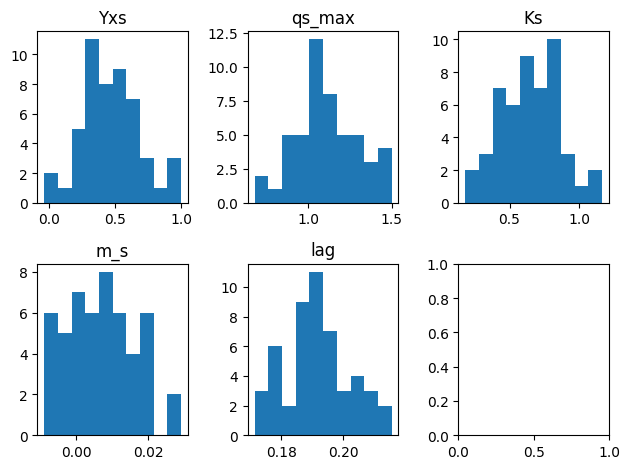

In [3]:
# check if there are enough samples to have a normal distribution
fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df_p['Yxs'])
ax[0,0].set_title('Yxs')
ax[0,1].hist(df_p['qs_max'])
ax[0,1].set_title('qs_max')
ax[0,2].hist(df_p['Ks'])
ax[0,2].set_title('Ks')
ax[1,0].hist(df_p['m_s'])
ax[1,0].set_title('m_s')
ax[1,1].hist(df_p['lag'])
ax[1,1].set_title('lag')
plt.tight_layout()

In [4]:
# Set the noise parameters
mean = 0  # Mean of the noise
std_dev = 0.1  # Standard deviation of the noise

In [5]:
# define sample frequency
# --> higher frequency reduces the amount of data that has to be stored
delta_t = 2 #[min]

df_batches = pd.DataFrame(columns=['time', 'biomass', 'glucose', 'batch_id'])
for i in range(df_p.shape[0]):
    batch_id = str(i).zfill(3)
    list_p = list(df_p.iloc[i])
    df = model(list_p, delta_t)
    df['batch_id'] = str(batch_id)
    
    # Add noise to the 'biomass' column
    noise_biomass = np.random.normal(mean, std_dev, df.shape[0])
    df['biomass'] += noise_biomass
    
    # Add noise to the 'glucose' column
    noise_glucose = np.random.normal(mean, std_dev, df.shape[0])
    df['glucose'] += noise_glucose

    df_batches = pd.concat([df_batches, df], ignore_index=True)

df_batches.to_csv('data/generated data/df1.csv')

Plot the variation among all batches

In [32]:
df1 = pd.read_csv('data/generated data/df_gen_0607.csv')

In [31]:
df1.drop(['Unnamed: 0'], axis=1, inplace=True)
df1['batch_id'] = df1['batch_id'].astype(str).str.zfill(3)

In [23]:
# biomass
df_X = df1.copy().drop(['glucose', 'qs'], axis=1)
sorted_X = df_X.groupby('batch_id')['biomass'].max().sort_values(ascending=False).index
df_X['batch_id'] = pd.Categorical(df_X['batch_id'], categories=sorted_X, ordered=True)
df_X = df_X.sort_values(['batch_id', 'time'], ascending=[True, True])

# glucose
df_S = df1.copy().drop(['biomass', 'qs'], axis=1)
sorted_S = df_S.groupby('batch_id')['glucose'].max().sort_values(ascending=False).index
df_S['batch_id'] = pd.Categorical(df_S['batch_id'], categories=sorted_S, ordered=True)
df_S = df_S.sort_values(['batch_id', 'time'], ascending=[True, True])

# qs
df_qs = df1.copy().drop(['biomass', 'glucose'], axis=1)
sorted_qs = df_qs.groupby('batch_id')['qs'].max().sort_values(ascending=False).index
df_qs['batch_id'] = pd.Categorical(df_qs['batch_id'], categories=sorted_qs, ordered=True)
df_qs = df_qs.sort_values(['batch_id', 'time'], ascending=[True, True])

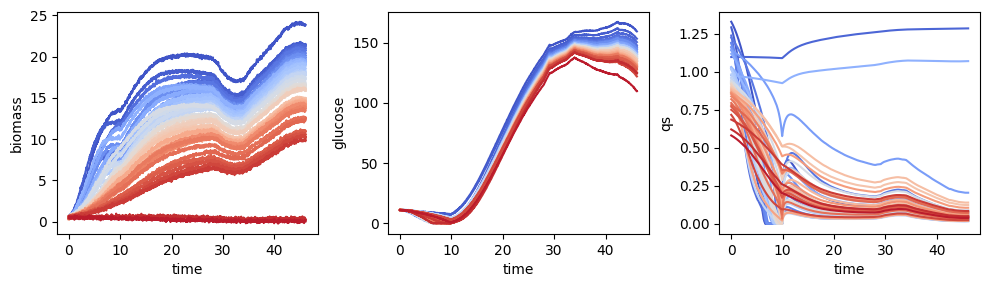

In [27]:
# Rainbow palette: Spectral
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

sns.lineplot(ax=ax[0], data=df_X, x='time', y='biomass', hue='batch_id', palette='coolwarm', legend=False)
sns.lineplot(ax=ax[1], data=df_S, x='time', y='glucose', hue='batch_id', palette='coolwarm', legend=False)
sns.lineplot(ax=ax[2], data=df_qs, x='time', y='qs', hue='batch_id', palette='coolwarm', legend=False)

plt.tight_layout()
plt.show()